# Imports

In [ ]:
#%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
import matplotlib.pyplot as plt
import seaborn as sn
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# extra imports
from pandas import read_csv
from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split,  KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegressionCV, LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from time import time
from datetime import timedelta
from sklearn.metrics import confusion_matrix, \
                  classification_report, accuracy_score,  precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import export_graphviz, DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')

# Previous Work

The original dataset is in ".arff" format. Conversion to python pandas is required.

In [ ]:
#pip install arff
#import arff
#from arff import load
# reading the dataset
#raw_data = loadarff('speeddating.arff')

# 'SD' stands for 'Speed Dating'
#SD = pd.DataFrame(raw_data[0])

In [ ]:
# peak into the data
#SD.head()

Categorical features seem to be in textiowrapper format, rather than string format. This needs to be fixed. 

In [ ]:
# take categorical features
#to_change = SD.columns[SD.dtypes=='O']

# remove b''
#for col in to_change:
#  for i in range(8378):
#    SD[col][i] = str(SD[col][i])[2:-1]

In [ ]:
#SD.head()

In [ ]:
#SD.to_csv('speeddating.csv',index=False)

# Resampling

We can now load our dataset directly from our *.csv* file.

In [ ]:
# Read csv
SD = pd.read_csv("speeddating.csv", delimiter=',')

Our goal is to predict whether a couple will end up being a match or not and to see which features play a the most significant role.
To do so, we shall split our data into a train set and a test set before any preprocessing of the data as to avoid contact between both sets as far as possible.

In [ ]:
# Partition according to target feature 'match'
X = SD
y = SD["match"]
y=y.astype('float64')

# Split into a train set and a test set
SD_train, SD_test, match_train, match_test = train_test_split(X, y, test_size=0.33, random_state=42)
X1_train, X_val, y1_train, y_val = train_test_split(SD_train, match_train, test_size=0.25, stratify=match_train, random_state=42)

# Preprocessing

Our dataset has 8378 observations and 123 variables, which is indeed big.

In [ ]:
# size of the dataset
SD.shape

(8378, 123)

Since our dataset has so many columns, we will adjust pandas so that all of them are shown during the execution process.

In [ ]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Feature extraction

In view of this, we must start by discarding some features. 

Our data set contains some features such as '*has_null*' which are superfluous for our analysis and, therefore, can be removed.

In [ ]:
# Remove "has_null" as it will not be needed during our analysis
SD_train.drop(columns="has_null", inplace=True)
SD_test.drop(columns="has_null", inplace=True)

Similarly, our purpose is to predict whether a couple ends up being a match or not. Therefore, since our target feature will be '*match*', columns '*decision*' and '*desicion_o*' shall be removed as, combined together, they give out the value of "match". In fact, if we fitted a model with these two features alone, its accuracy would be of 100%. Therefore, including them is absurd.

<Axes: >

Text(0.5, 1.0, 'Correlation with feature "match"')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Correlation')

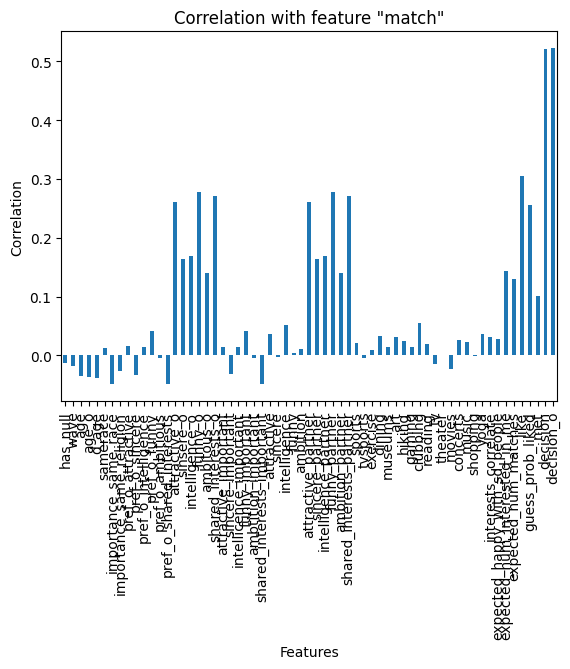

In [ ]:
# Calculate correlation with target feature
correlation = SD.corr()['match'].drop('match')

# Plot correlation
correlation.plot(kind='bar')
plt.title('Correlation with feature "match"')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

In [ ]:
# Remove "decision" along with "decision_o" as, combined together, are "match" 
SD_train.drop(columns="decision", inplace=True)
SD_train.drop(columns="decision_o", inplace=True)
SD_test.drop(columns="decision", inplace=True)
SD_test.drop(columns="decision_o", inplace=True)

Lastly, feature '*field*' will also be removed as including it would be unuseful due to its excessive ammount of categories (56, to be precise).

<Axes: xlabel='field', ylabel='Count'>

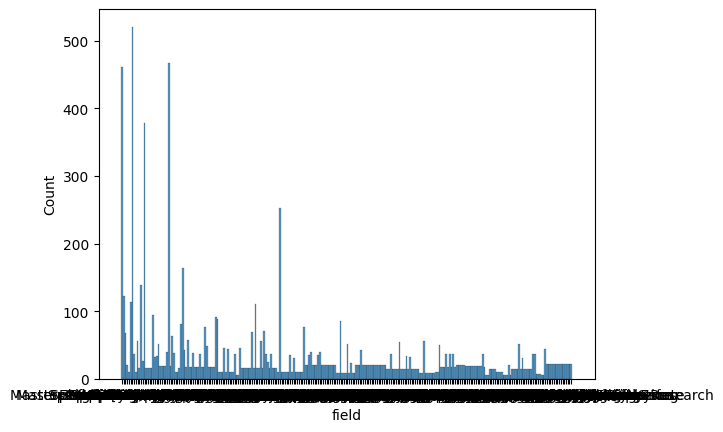

In [ ]:
# Plot distribution of feature "attractive"
sn.histplot(data=SD, x="field")

In [ ]:
# Remove "field" 
SD_train.drop(columns="field", inplace=True)
SD_test.drop(columns="field", inplace=True)

## Treatment of mixed Data Types

In [ ]:
SD.dtypes

has_null                             int64
wave                               float64
gender                              object
age                                float64
age_o                              float64
d_age                              float64
d_d_age                             object
race                                object
race_o                              object
samerace                             int64
importance_same_race               float64
importance_same_religion           float64
d_importance_same_race              object
d_importance_same_religion          object
field                               object
pref_o_attractive                  float64
pref_o_sincere                     float64
pref_o_intelligence                float64
pref_o_funny                       float64
pref_o_ambitious                   float64
pref_o_shared_interests            float64
d_pref_o_attractive                 object
d_pref_o_sincere                    object
d_pref_o_in

There are 60 categorical variables (originally 64). However, non of these variables have missing values. If there were to be any, we would remove them.

In [ ]:
# Count categorical features
SD_train.dtypes[SD.dtypes == 'object'].count() + SD_train.dtypes[SD.dtypes == 'int64'].count()

60

In [ ]:
# Get missing values
SD_train.select_dtypes(include="object").isna().any()
SD_train.select_dtypes(include="int64").isna().any()

gender                             False
d_d_age                            False
race                               False
race_o                             False
d_importance_same_race             False
d_importance_same_religion         False
d_pref_o_attractive                False
d_pref_o_sincere                   False
d_pref_o_intelligence              False
d_pref_o_funny                     False
d_pref_o_ambitious                 False
d_pref_o_shared_interests          False
d_attractive_o                     False
d_sinsere_o                        False
d_intelligence_o                   False
d_funny_o                          False
d_ambitous_o                       False
d_shared_interests_o               False
d_attractive_important             False
d_sincere_important                False
d_intellicence_important           False
d_funny_important                  False
d_ambtition_important              False
d_shared_interests_important       False
d_attractive    

samerace    False
match       False
dtype: bool

Similarly, there are 59 numerical variables, 57 of which have missing values!

In [ ]:
# Count numerical features
SD_train.dtypes[SD_train.dtypes == 'float64'].count()

59

In [ ]:
# Get missing values
SD_train.select_dtypes(include="float64").isna().any()

wave                             False
age                               True
age_o                             True
d_age                            False
importance_same_race              True
importance_same_religion          True
pref_o_attractive                 True
pref_o_sincere                    True
pref_o_intelligence               True
pref_o_funny                      True
pref_o_ambitious                  True
pref_o_shared_interests           True
attractive_o                      True
sinsere_o                         True
intelligence_o                    True
funny_o                           True
ambitous_o                        True
shared_interests_o                True
attractive_important              True
sincere_important                 True
intellicence_important            True
funny_important                   True
ambtition_important               True
shared_interests_important        True
attractive                        True
sincere                  

We notice some of these variables are labeled as numeric but in fact are not. This can be seen by computing their distribution's histogram, which sometimes reveals a distribution typical of categorical features.

<Axes: xlabel='attractive', ylabel='Count'>

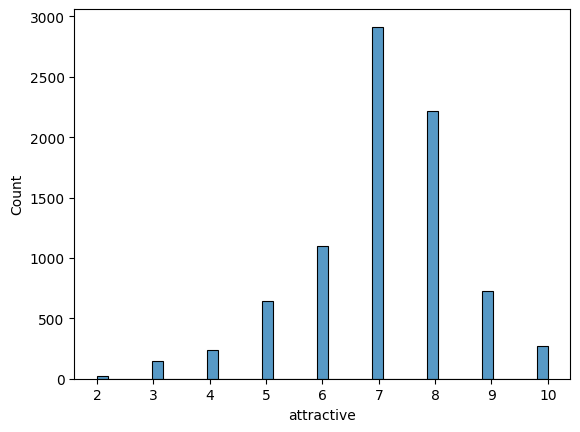

In [ ]:
# Plot distribution of feature "attractive"
sn.histplot(data=SD, x="attractive")

In [ ]:
# List false numerical variables
false_numericals = ["expected_happy_with_sd_people", "importance_same_race", "importance_same_religion", "d_importance_same_race", "d_importance_same_religion", "attractive", "sincere", "intelligence", "funny", "ambition", "sports", "tvsports", "exercise", "dining", "museums", "art", "hiking", "gaming", "clubbing", "reading", "tv", "theater", "movies", "concerts", "music", "shopping", "yoga", "met", "samerace", "match"]
# Re-label false numerical variables as categoricals 
SD_train[false_numericals] = SD_train[false_numericals].astype(object)
SD_test[false_numericals] = SD_test[false_numericals].astype(object)

We are now down to 86 categorical features and 33 numerical features.

In [ ]:
print("Categoricals: ", SD_train.dtypes[SD_train.dtypes == 'object'].count(), " Numericals: ", SD_train.dtypes[SD_train.dtypes == 'float64'].count())

Categoricals:  86  Numericals:  33



## Missing values

By first glance at our data, it can be seen that the mean, minimum and maximum for most variables is in range with what we would have expected. 
It also seems that some variables which refer to partner's score rate out of 10, while some rate out of 100. This calls for future standarization. 
We further notice that most of the variables shown above have missing values, as the total 'count' is under 8378.

In [ ]:
SD.describe()
SD_before = SD

,has_null,wave,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,decision,decision_o,match
count,8378.00000,8378.000000,8283.000000,8274.000000,8378.000000,8378.000000,8299.000000,8299.000000,8289.000000,8289.000000,8289.000000,8280.000000,8271.000000,8249.000000,8166.000000,8091.000000,8072.000000,8018.000000,7656.000000,7302.000000,8299.000000,8299.000000,8299.000000,8289.000000,8279.000000,8257.000000,8273.000000,8273.000000,8273.000000,8273.000000,8273.000000,8176.000000,8101.000000,8082.000000,8028.000000,7666.000000,7311.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8299.000000,8220.000000,8277.000000,1800.000000,7205.000000,8138.000000,8069.000000,8003.000000,8378.000000,8378.000000,8378.000000
mean,0.87491,11.350919,26.358928,26.364999,4.185605,0.395799,3.784793,3.651645,22.495347,17.396867,20.270759,17.459714,10.685375,11.845930,6.190411,7.175256,7.369301,6.400599,6.778409,5.474870,22.514632,17.396389,20.265613,17.457043,10.682539,11.845111,7.084733,8.294935,7.704460,8.403965,7.578388,6.189995,7.175164,7.368597,6.400598,6.777524,5.474559,6.425232,4.575491,6.245813,7.783829,6.985781,6.714544,5.737077,3.881191,5.745993,7.678515,5.304133,6.776118,7.919629,6.825401,7.851066,5.631281,4.339197,0.196010,5.534131,5.570556,3.207814,6.134087,5.207523,0.049856,0.419909,0.419551,0.164717
std,0.33084,5.995903,3.566763,3.563648,4.596171,0.489051,2.845708,2.805237,12.569802,7.044003,6.782895,6.085526,6.126544,6.362746,1.950305,1.740575,1.550501,1.954078,1.794080,2.156163,12.587674,7.046700,6.783003,6.085239,6.124888,6.362154,1.395783,1.407460,1.564321,1.076608,1.778315,1.950169,1.740315,1.550453,1.953702,1.794055,2.156363,2.619024,2.801874,2.418858,1.754868,2.052232,2.263407,2.570207,2.620507,2.502218,2.006565,2.529135,2.235152,1.700927,2.156283,1.791827,2.608913,2.717612,0.303539,1.734059,4.762569,2.444813,1.841285,2.129565,0.282168,0.493573,0.493515,0.370947
min,0.00000,1.000000,18.000000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-0.830000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,7.000000,24.000000,24.000000,1.000000,0.000000,1.000000,1.000000,15.000000,15.000000,17.390000,15.000000,5.000000,9.520000,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,15.000000,15.000000,17.390000,15.000000,5.000000,9.520000,6.000000,8.000000,7.000000,8.000000,7.000000,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,4.000000,2.000000,5.000000,7.000000,6.000000,5.000000,4.000000,2.000000,4.000000,7.000000,3.000000,5.000000,7.000000,5.000000,7.000000,4.000000,2.000000,-0.020000,5.000000,2.000000,2.000000,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,11.000000,26.000000,26.000000,3.000000,

By inspecting our data set, we notice that some features such as '*expected_num_interested_in_me*', '*expected_num_matches*', '*shared_interests_partner*' or '*shared_interests_o*' have an incredible large amount of missing values. Before treating missing values in observations, these features shall be removed. Otherwise, we would have to absurdly delete too many observations. 

In [ ]:
print('Total missing values of expected_num_interested_in_me: ', SD['expected_num_interested_in_me'].isna().sum())
SD_train.drop(columns="expected_num_interested_in_me", inplace=True)
SD_test.drop(columns="expected_num_interested_in_me", inplace=True)

Total missing values of expected_num_interested_in_me:  6578


In [ ]:
print('Total missing values of expected_num_matches: ', SD['expected_num_matches'].isna().sum())
SD_train.drop(columns="expected_num_matches", inplace=True)
SD_test.drop(columns="expected_num_matches", inplace=True)

Total missing values of expected_num_matches:  1173


In [ ]:
print('Total missing values of shared_interests_o: ', SD['shared_interests_o'].isna().sum())
SD_train.drop(columns="shared_interests_o", inplace=True)
SD_test.drop(columns="shared_interests_o", inplace=True)

Total missing values of shared_interests_o:  1076


In [ ]:
print('Total missing values of shared_interests_partner: ', SD['shared_interests_partner'].isna().sum())
SD_train.drop(columns="shared_interests_partner", inplace=True)
SD_test.drop(columns="shared_interests_partner", inplace=True)

Total missing values of shared_interests_partner:  1067


Then, if '*shared_interests_o*' and '*shared_interests_partner*' are deleted, one might as well delete related features regardless of missing values

In [ ]:
SD_train.drop(columns="shared_interests_important", inplace=True)
SD_test.drop(columns="shared_interests_important", inplace=True)

SD_train.drop(columns="pref_o_shared_interests", inplace=True)
SD_test.drop(columns="pref_o_shared_interests", inplace=True)

We now can now delete observations containing missing values. 

In [ ]:
print("From: ", SD_train.shape, " to: ", SD_train.dropna().shape)
print("From: ", SD_test.shape, " to: ", SD_test.dropna().shape)

From:  (5613, 113)  to:  (4372, 113)
From:  (2765, 113)  to:  (2131, 113)


As we only have 2 numerical features that do not containg missing values, performing KNN to impute our missing data does not seem reasonable.
Instead, let us drop missing observations. 

In [ ]:
# Drop all missing observations
SD_train = SD_train.dropna()
SD_test = SD_test.dropna()

# Keep the same observations for partitioned column 'match'
match_train = SD_train["match"]
match_test = SD_test["match"]

## Outliers

### Feature *'met'*

Categorical feature *'met'* ("Have you met your partner before?") is suposed to be binary (yes/no).\
For unknown reasons, this does not seem to be the case.

In [ ]:
SD.met.value_counts()
SD.shape

0.0    7644
1.0     351
7.0       3
5.0       2
3.0       1
8.0       1
6.0       1
Name: met, dtype: int64

(8378, 123)

Therefore, values above 1 must be treated by either replacing them with 1 (as values x > 1 could mean that the couple had met x times prior to the date) or replacing them with NANs. Either one of these strategies will lead to similar results as its effect will only be seen in 8 observations out of a total of over 6000.

In [ ]:
# Replace values greater than 1 with 1
SD_train.loc[SD_train['met'] > 1, 'met'] = 1
SD_test.loc[SD_test['met'] > 1, 'met'] = 1

In [ ]:
# Alternatively, replace values greater than 1 with NANs
# SD_train['met'] = SD_train['met'].apply(lambda x: x if x <= 1 else None)
# SD_train.dropna(subset=['met'], inplace=True)
# SD_train['met'].astype(object)

# SD_test['met'] = SD_test['met'].apply(lambda x: x if x <= 1 else None)
# SD_test.dropna(subset=['met'], inplace=True)
# SD_test['met'].astype(object)

Our feature is now binary!

In [ ]:
SD_train['met'].value_counts()

0.0    4157
1.0     215
Name: met, dtype: int64

## One-hot-encoding

In [ ]:
# Remove target feature 'match'
SD_train.drop(columns='match', inplace=True)
SD_test.drop(columns='match', inplace=True)

# Get categorical features
categorical_features = SD_train.dtypes[SD_train.dtypes == 'object'].index.values.tolist()

# Save data set prior to one-hot-encoding
SD_train_noencoding = SD_train
SD_test_noenconding = SD_test

# Preprocess categorical variables using one-hot-encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ], remainder='passthrough'
)

In [ ]:
def one_hot_encoding(X, y):
  # Perform one-hot-encoding
  pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
  out = pipeline.fit_transform(X, y)
  result = pd.DataFrame(out.toarray())
  return result

SD_train = one_hot_encoding(SD_train, match_train)
SD_test = one_hot_encoding(SD_test, match_test)

In [ ]:
SD_train
SD_train.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.0,22.0,27.0,5.0,30.00,15.00,15.00,20.00,5.00,7.0,7.0,6.0,7.0,7.0,20.00,10.00,20.00,20.00,20.00,4.0,8.0,7.0,7.0,6.0,0.54,6.0,6.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

(4372, 458)

We now have 435 categorical columns (458 columns in total). Let's re-label them so our result can be interpreted.


In [ ]:
from sqlalchemy.sql.expression import all_

# List categorical features
categorical_features = SD_train_noencoding.dtypes[SD_train_noencoding.dtypes == 'object'].index.values.tolist()
# List numerical features
numerical_features = SD_train_noencoding.dtypes[SD_train_noencoding.dtypes == 'float64'].index.values.tolist()

# Create empty list of column names 
all_columns = []

# For every categorical feature
for feature in categorical_features:
  # Compute the total of categories
  total = len(SD_train_noencoding[feature].unique());
  # Get categorical columns' names
  all_columns = all_columns + [feature + '_' + str(i) for i in range(total)]

# For every numerical feature
for feature in numerical_features:
  # Get numerical columns' names
  all_columns = all_columns + [feature] 

len(all_columns)

458

In [ ]:
# Update data frame's header
SD_train.columns = all_columns
SD_test.columns = all_columns

SD_train.head()

,gender_0,gender_1,d_d_age_0,d_d_age_1,d_d_age_2,d_d_age_3,race_0,race_1,race_2,race_3,race_4,race_o_0,race_o_1,race_o_2,race_o_3,race_o_4,samerace_0,samerace_1,importance_same_race_0,importance_same_race_1,importance_same_race_2,importance_same_race_3,importance_same_race_4,importance_same_race_5,importance_same_race_6,importance_same_race_7,importance_same_race_8,importance_same_race_9,importance_same_race_10,importance_same_religion_0,importance_same_religion_1,importance_same_religion_2,importance_same_religion_3,importance_same_religion_4,importance_same_religion_5,importance_same_religion_6,importance_same_religion_7,importance_same_religion_8,importance_same_religion_9,d_importance_same_race_0,d_importance_same_race_1,d_importance_same_race_2,d_importance_same_religion_0,d_importance_same_religion_1,d_importance_same_religion_2,d_pref_o_attractive_0,d_pref_o_attractive_1,d_pref_o_attractive_2,d_pref_o_sincere_0,d_pref_o_sincere_1,d_pref_o_sincere_2,d_pref_o_intelligence_0,d_pref_o_intelligence_1,d_pref_o_intelligence_2,d_pref_o_funny_0,d_pref_o_funny_1,d_pref_o_funny_2,d_pref_o_ambitious_0,d_pref_o_ambitious_1,d_pref_o_ambitious_2,d_pref_o_shared_interests_0,d_pref_o_shared_interests_1,d_pref_o_shared_interests_2,d_attractive_o_0,d_attractive_o_1,d_attractive_o_2,d_sinsere_o_0,d_sinsere_o_1,d_sinsere_o_2,d_intelligence_o_0,d_intelligence_o_1,d_intelligence_o_2,d_funny_o_0,d_funny_o_1,d_funny_o_2,d_ambitous_o_0,d_ambitous_o_1,d_ambitous_o_2,d_shared_interests_o_0,d_shared_interests_o_1,d_shared_interests_o_2,d_attractive_important_0,d_attractive_important_1,d_attractive_important_2,d_sincere_important_0,d_sincere_important_1,d_sincere_important_2,d_intellicence_important_0,d_intellicence_important_1,d_intellicence_important_2,d_funny_important_0,d_funny_important_1,d_funny_important_2,d_ambtition_important_0,d_ambtition_important_1,d_ambtition_important_2,d_shared_interests_important_0,d_shared_interests_important_1,d_shared_interests_important_2,attractive_0,attractive_1,attractive_2,attractive_3,attractive_4,attractive_5,attractive_6,attractive_7,attractive_8,sincere_0,sincere_1,sincere_2,sincere_3,sincere_4,sincere_5,sincere_6,sincere_7,sincere_8,intelligence_0,intelligence_1,intelligence_2,intelligence_3,intelligence_4,intelligence_5,intelligence_6,intelligence_7,intelligence_8,funny_0,funny_1,funny_2,funny_3,funny_4,funny_5,funny_6,funny_7,ambition_0,ambition_1,ambition_2,ambition_3,ambition_4,ambition_5,ambition_6,ambition_7,ambition_8,d_attractive_0,d_attractive_1,d_attractive_2,d_sincere_0,d_sincere_1,d_sincere_2,d_intelligence_0,d_intelligence_1,d_intelligence_2,d_funny_0,d_funny_1,d_funny_2,d_ambition_0,d_ambition_1,d_ambition_2,d_attractive_partner_0,d_attractive_partner_1,d_attractive_partner_2,d_sincere_partner_0,d_sincere_partner_1,d_sincere_partner_2,d_intelligence_partner_0,d_intelligence_partner_1,d_intelligence_partner_2,d_funny_partner_0,d_funny_partner_1,d_funny_partner_2,d_ambition_partner_0,d_ambition_partner_1,d_ambition_partner_2,d_shared_interests_partner_0,d_shared_interests_partner_1,d_shared_interests_partner_2,sports_0,sports_1,sports_2,sports_3,sports_4,sports_5,sports_6,sports_7,sports_8,sports_9,tvsports_0,tvsports_1,tvsports_2,tvsports_3,tvsports_4,tvsports_5,tvsports_6,tvsports_7,tvsports_8,tvsports_9,exercise_0,exercise_1,exercise_2,exercise_3,exercise_4,exercise_5,exercise_6,exercise_7,exercise_8,exercise_9,dining_0,dining_1,dining_2,dining_3,dining_4,dining_5,dining_6,dining_7,dining_8,dining_9,museums_0,museums_1,museums_2,museums_3,museums_4,museums_5,museums_6,museums_7,museums_8,museums_9,art_0,art_1,art_2,art_3,art_4,art_5,art_6,art_7,art_8,art_9,hiking_0,hiking_1,hiking_2,hiking_3,hiking_4,hiking_5,hiking_6,hiking_7,hiking_8,hiking_9,hiking_10,gaming_0,gaming_1,gaming_2,gaming_3,gaming_4,gaming_5,gaming_6,gaming_7,gaming_8,gaming_9,gaming_10,gaming_11,clubbing_0,clubbing_1,clubbing_2,clubbing_3,clubbing_4,clubbing_5,clubbing_6,clubbing_7,clubbing_8,clubbing_9,reading_0,reading_1

We can now extract our own conclusions.

Refering to categorical features, we have:
- Binary variables [0-1]: gender, samerace, met...

- 3 categories: variables starting with "d_" (intervals)
- 4 categories: d_d_age (4 groups of age)
- 5 categories: race (5 races)

- Ratings [0-10]: importance_same_religion, importance_same_race, expected_happy_with_sd_people, all self traits (attractive, sincere, intelligence, ambition, funny) and all hobbies (sports, tvsports, exercise, dining, museums, art, hiking, gaming, clubbing, reading, tv, theater, movies, concerts, music, shopping, yoga).


(Variable "field" has been removed as there would have been 56 more columns)

## Normalization

Our continuous features should look Gaussian. 

In [ ]:
# Get numerical features
numerical_features = SD_train_noencoding.dtypes[SD_train_noencoding.dtypes == 'float64'].index.values
# Take a subset containing numerical features only
SD_train_numerical = SD_train[numerical_features]

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'wave')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'age')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'age_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'd_age')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_attractive')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_sincere')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_intelligence')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_funny')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_ambitious')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'attractive_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'sinsere_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'intelligence_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'funny_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'ambitous_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'attractive_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'sincere_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'intellicence_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'funny_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'ambtition_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'attractive_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'sincere_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'intelligence_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'funny_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'ambition_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'interests_correlate')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'like')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'guess_prob_liked')

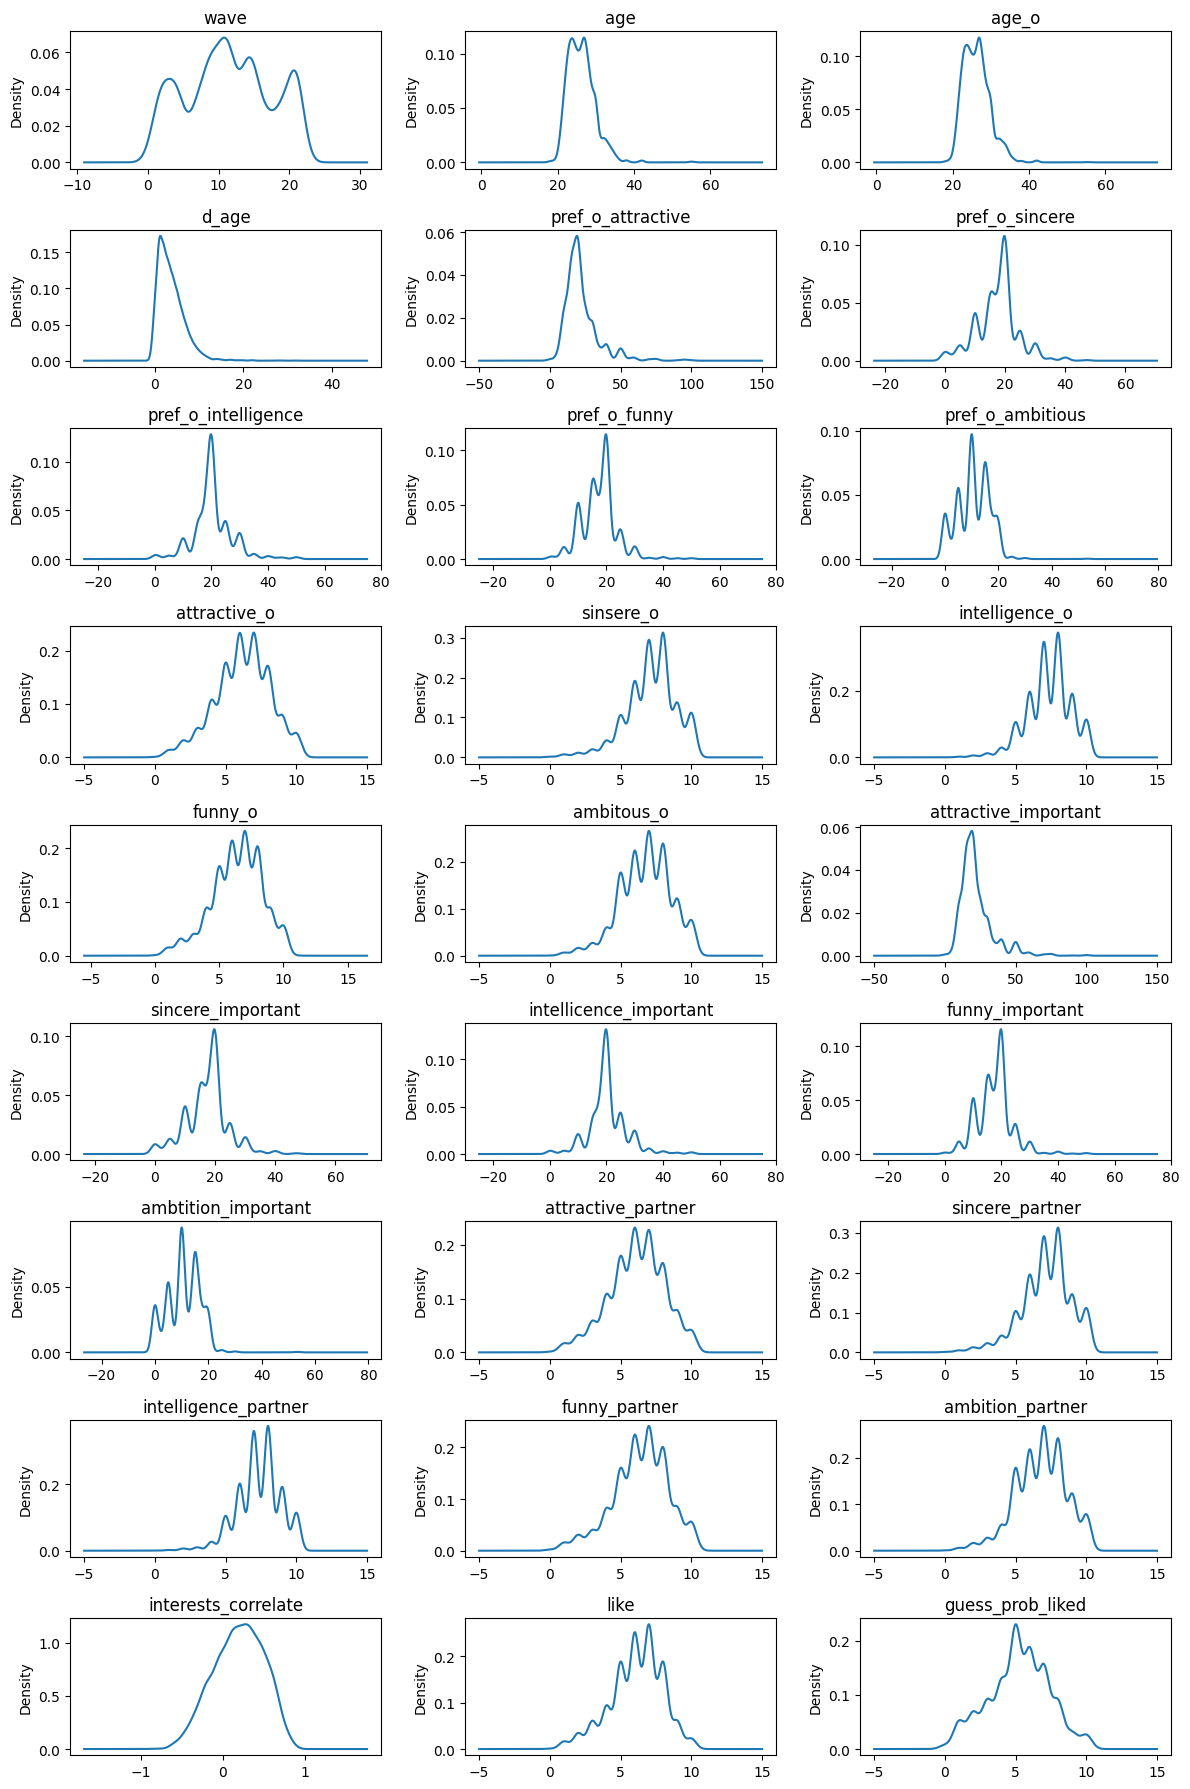

In [ ]:
num_plots = len(numerical_features)
num_rows = 9
num_cols = 3 

fig = plt.figure(figsize=(12, 18))

for i, feature in enumerate(numerical_features):
    # Calculate the subplot position
    row_pos = i // num_cols + 1  # Floor division to get the row position
    col_pos = i % num_cols + 1  # Modulo operation to get the column position
    # Create a new subplot
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    # Plot the data
    SD_train_numerical[feature].plot.kde()
    ax.set_title(feature)
plt.tight_layout()
plt.show()

Notice how, why they mostly do look Gaussian, the range varies. This calls for employing normalization methods.

Scaling process needs to be different for the training and test set so as to make things compatible with the fact that we cannot use information from the test set to do the scaling. 

For the train set, we will be using Min-max scaling: $\frac{X - X_{min}}{X_{max} - X_{min}}$, which will send our continuous data to the range [0,1].

In [ ]:
numerical_features = SD_train_noencoding.dtypes[SD_train_noencoding.dtypes == 'float64'].index.values

def preprocessing(X, y, scaler=None):    
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        # Normalize the training data using Min-Max scaling
        X.loc[:,numerical_features] = scaler.fit_transform(X[numerical_features])
    else: 
        X.loc[:,numerical_features] = scaler.transform(X[numerical_features]) 
    return X, y, scaler

X_train, y_train, scaler = preprocessing(SD_train,match_train)
X_test, y_test, _ = preprocessing(SD_test,match_test,scaler)
y_test=y_test.astype('float64')
y_train=y_train.astype('float64')

Let us repeat the previous plot with the normalized data to check that the range has changed.

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'wave')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'age')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'age_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'd_age')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_attractive')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_sincere')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_intelligence')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_funny')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'pref_o_ambitious')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'attractive_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'sinsere_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'intelligence_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'funny_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'ambitous_o')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'attractive_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'sincere_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'intellicence_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'funny_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'ambtition_important')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'attractive_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'sincere_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'intelligence_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'funny_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'ambition_partner')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'interests_correlate')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'like')

<Axes: ylabel='Density'>

Text(0.5, 1.0, 'guess_prob_liked')

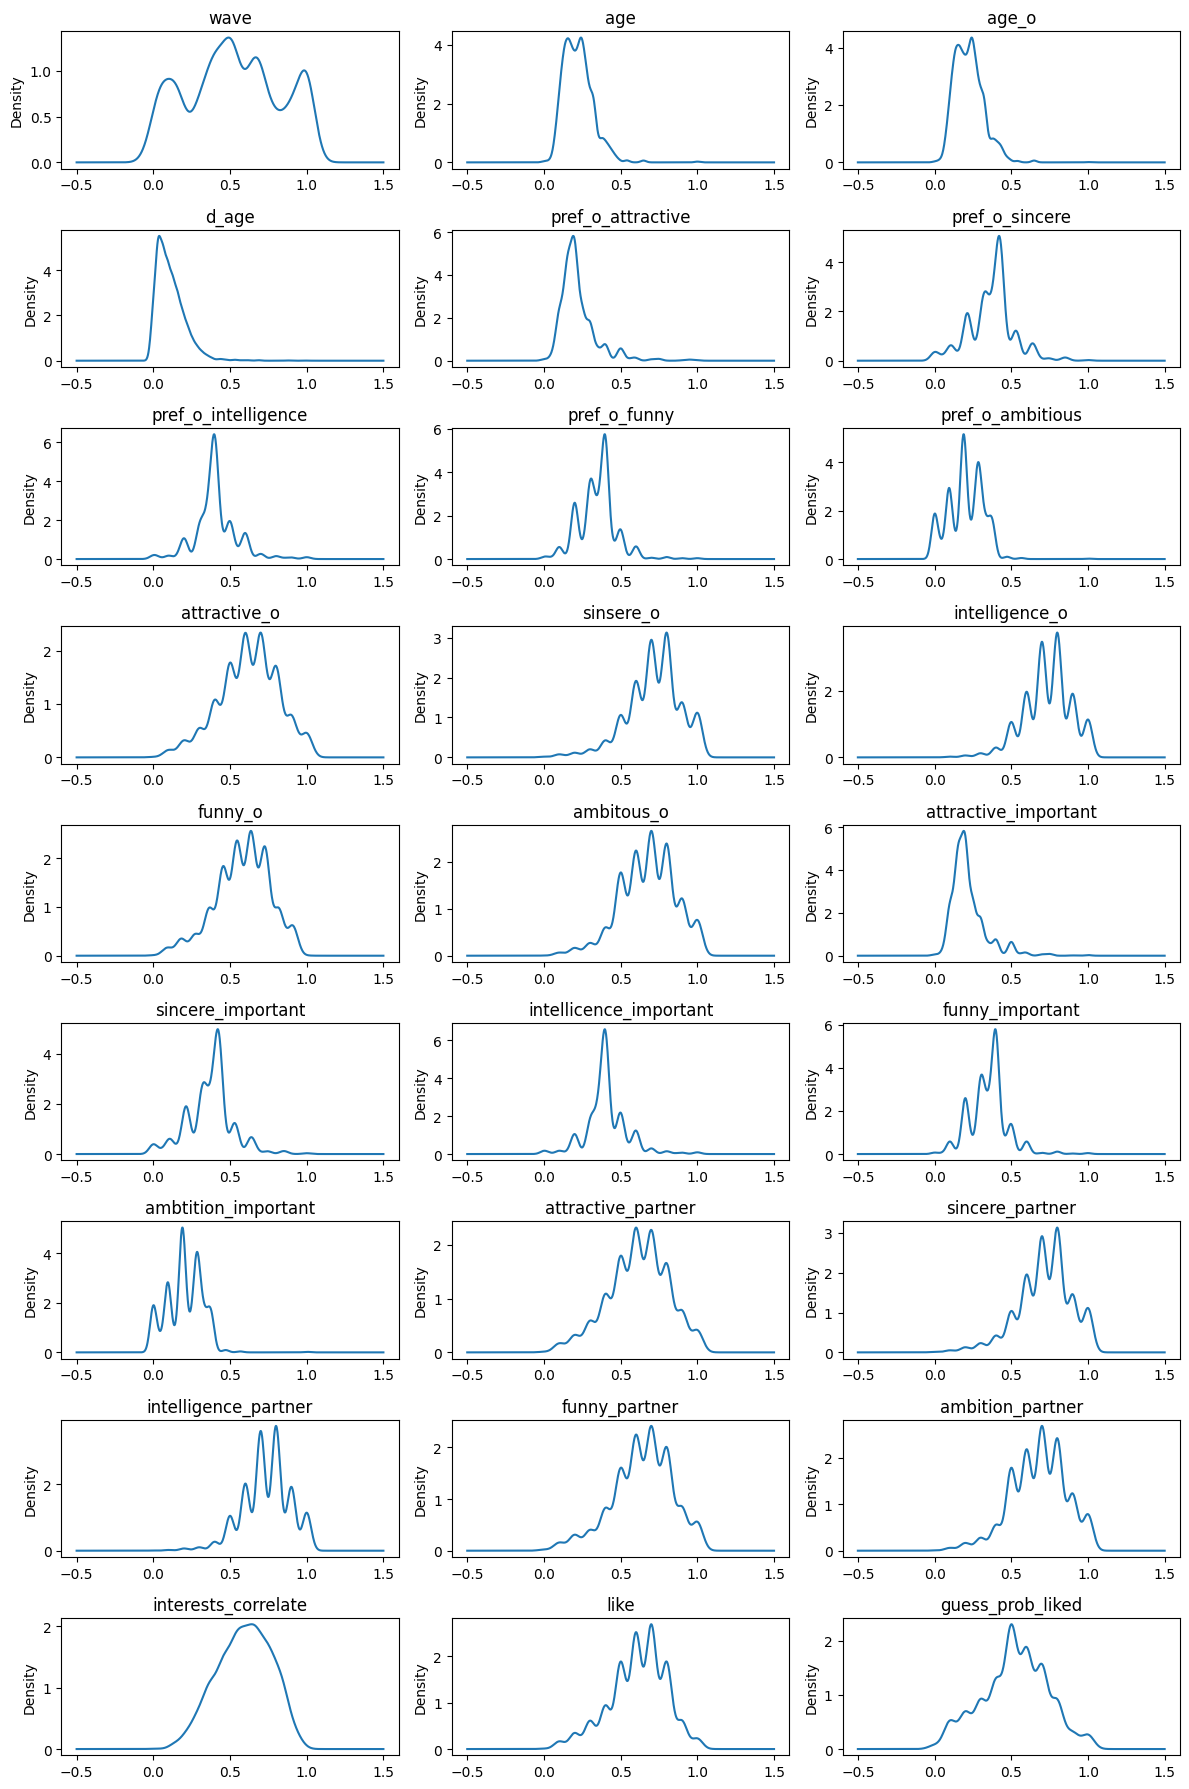

In [ ]:
num_plots = len(numerical_features)
num_rows = 9
num_cols = 3 

fig = plt.figure(figsize=(12, 18))

for i, feature in enumerate(numerical_features):
    # Calculate the subplot position
    row_pos = i // num_cols + 1  # Floor division to get the row position
    col_pos = i % num_cols + 1  # Modulo operation to get the column position
    # Create a new subplot
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    # Plot the data
    X_train[feature].plot.kde()
    ax.set_title(feature)
plt.tight_layout()
plt.show()

# Linear Classification

We will now perform linear classification onto our preprocessed data set.

## Metrics

While we have already pre-processed our data set (missing values, one-hot-encoding, normalization...), scaling process needs to be different for the training and test set so as to make things compatible with the fact that we cannot use information from the test set to do the scaling. Therefore, we shall use our unscaled data set to properly scale both sets.

As we fit several models, we will be computing their respective performance metrics using cross validation. At the moment, we will be using the model 

In [ ]:
# Create data frame to store metrics obtained with cross validation
metrics = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [ ]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## LDA

Linear Discriminant Analysis tries to model the probability $p(y=C_k|X=x)$ by assuming: 
* $p(x|C_k)$ is Gaussian (which means that can be described by $\mu_k$ and $\Sigma_k$)
* All covariance matrix are the same ($\Sigma_k = \Sigma$)

By using bayes formula ($p(A|B) = \frac{P(B|A)P(A)}{P(B)}$) and all these asumptions, we obtain the next discriminant function:

$a_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

Where $\pi_k$ are the prior probabilities. 

In [ ]:
lda_model = LinearDiscriminantAnalysis()
lda_model = lda_model.fit(X_train, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=SD_train.columns[0:]
means.index = lda_model.classes_
means

Priors: [0.8268527 0.1731473]
Means:



,gender_0,gender_1,d_d_age_0,d_d_age_1,d_d_age_2,d_d_age_3,race_0,race_1,race_2,race_3,race_4,race_o_0,race_o_1,race_o_2,race_o_3,race_o_4,samerace_0,samerace_1,importance_same_race_0,importance_same_race_1,importance_same_race_2,importance_same_race_3,importance_same_race_4,importance_same_race_5,importance_same_race_6,importance_same_race_7,importance_same_race_8,importance_same_race_9,importance_same_race_10,importance_same_religion_0,importance_same_religion_1,importance_same_religion_2,importance_same_religion_3,importance_same_religion_4,importance_same_religion_5,importance_same_religion_6,importance_same_religion_7,importance_same_religion_8,importance_same_religion_9,d_importance_same_race_0,d_importance_same_race_1,d_importance_same_race_2,d_importance_same_religion_0,d_importance_same_religion_1,d_importance_same_religion_2,d_pref_o_attractive_0,d_pref_o_attractive_1,d_pref_o_attractive_2,d_pref_o_sincere_0,d_pref_o_sincere_1,d_pref_o_sincere_2,d_pref_o_intelligence_0,d_pref_o_intelligence_1,d_pref_o_intelligence_2,d_pref_o_funny_0,d_pref_o_funny_1,d_pref_o_funny_2,d_pref_o_ambitious_0,d_pref_o_ambitious_1,d_pref_o_ambitious_2,d_pref_o_shared_interests_0,d_pref_o_shared_interests_1,d_pref_o_shared_interests_2,d_attractive_o_0,d_attractive_o_1,d_attractive_o_2,d_sinsere_o_0,d_sinsere_o_1,d_sinsere_o_2,d_intelligence_o_0,d_intelligence_o_1,d_intelligence_o_2,d_funny_o_0,d_funny_o_1,d_funny_o_2,d_ambitous_o_0,d_ambitous_o_1,d_ambitous_o_2,d_shared_interests_o_0,d_shared_interests_o_1,d_shared_interests_o_2,d_attractive_important_0,d_attractive_important_1,d_attractive_important_2,d_sincere_important_0,d_sincere_important_1,d_sincere_important_2,d_intellicence_important_0,d_intellicence_important_1,d_intellicence_important_2,d_funny_important_0,d_funny_important_1,d_funny_important_2,d_ambtition_important_0,d_ambtition_important_1,d_ambtition_important_2,d_shared_interests_important_0,d_shared_interests_important_1,d_shared_interests_important_2,attractive_0,attractive_1,attractive_2,attractive_3,attractive_4,attractive_5,attractive_6,attractive_7,attractive_8,sincere_0,sincere_1,sincere_2,sincere_3,sincere_4,sincere_5,sincere_6,sincere_7,sincere_8,intelligence_0,intelligence_1,intelligence_2,intelligence_3,intelligence_4,intelligence_5,intelligence_6,intelligence_7,intelligence_8,funny_0,funny_1,funny_2,funny_3,funny_4,funny_5,funny_6,funny_7,ambition_0,ambition_1,ambition_2,ambition_3,ambition_4,ambition_5,ambition_6,ambition_7,ambition_8,d_attractive_0,d_attractive_1,d_attractive_2,d_sincere_0,d_sincere_1,d_sincere_2,d_intelligence_0,d_intelligence_1,d_intelligence_2,d_funny_0,d_funny_1,d_funny_2,d_ambition_0,d_ambition_1,d_ambition_2,d_attractive_partner_0,d_attractive_partner_1,d_attractive_partner_2,d_sincere_partner_0,d_sincere_partner_1,d_sincere_partner_2,d_intelligence_partner_0,d_intelligence_partner_1,d_intelligence_partner_2,d_funny_partner_0,d_funny_partner_1,d_funny_partner_2,d_ambition_partner_0,d_ambition_partner_1,d_ambition_partner_2,d_shared_interests_partner_0,d_shared_interests_partner_1,d_shared_interests_partner_2,sports_0,sports_1,sports_2,sports_3,sports_4,sports_5,sports_6,sports_7,sports_8,sports_9,tvsports_0,tvsports_1,tvsports_2,tvsports_3,tvsports_4,tvsports_5,tvsports_6,tvsports_7,tvsports_8,tvsports_9,exercise_0,exercise_1,exercise_2,exercise_3,exercise_4,exercise_5,exercise_6,exercise_7,exercise_8,exercise_9,dining_0,dining_1,dining_2,dining_3,dining_4,dining_5,dining_6,dining_7,dining_8,dining_9,museums_0,museums_1,museums_2,museums_3,museums_4,museums_5,museums_6,museums_7,museums_8,museums_9,art_0,art_1,art_2,art_3,art_4,art_5,art_6,art_7,art_8,art_9,hiking_0,hiking_1,hiking_2,hiking_3,hiking_4,hiking_5,hiking_6,hiking_7,hiking_8,hiking_9,hiking_10,gaming_0,gaming_1,gaming_2,gaming_3,gaming_4,gaming_5,gaming_6,gaming_7,gaming_8,gaming_9,gaming_10,gaming_11,clubbing_0,clubbing_1,clubbing_2,clubbing_3,clubbing_4,clubbing_5,clubbing_6,clubbing_7,clubbing_8,clubbing_9,reading_0,reading_1

In [ ]:
# Compute cross-validation metrics for LDA
cross_val_results = pd.DataFrame(cross_validate(lda_model , X_train, y_train, cv = 5, 
                            scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics.loc['LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


In [ ]:
# Compute confusion matrix
confusion(y_train, pd.Series(lda_model.predict(X_train)))   

predicted,0.0,1.0
target,,
0.0,3473,142
1.0,397,360


## QDA
Quadratic Discriminant Analysis is very similar to LDA. The main difference is that in this model we do not assume that all the classes have the same covariance matrices. This leads to obtaining a quadratic decision surface. This model can also be regularized with its regularization parameter.

In [ ]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.1).fit(X_train, y_train)

print('Priors:', qda_model.priors_)
print('Means:\n')
means =pd.DataFrame(qda_model.means_)
means.columns=SD_train.columns[0:]
means

Priors: [0.8268527 0.1731473]
Means:



,gender_0,gender_1,d_d_age_0,d_d_age_1,d_d_age_2,d_d_age_3,race_0,race_1,race_2,race_3,race_4,race_o_0,race_o_1,race_o_2,race_o_3,race_o_4,samerace_0,samerace_1,importance_same_race_0,importance_same_race_1,importance_same_race_2,importance_same_race_3,importance_same_race_4,importance_same_race_5,importance_same_race_6,importance_same_race_7,importance_same_race_8,importance_same_race_9,importance_same_race_10,importance_same_religion_0,importance_same_religion_1,importance_same_religion_2,importance_same_religion_3,importance_same_religion_4,importance_same_religion_5,importance_same_religion_6,importance_same_religion_7,importance_same_religion_8,importance_same_religion_9,d_importance_same_race_0,d_importance_same_race_1,d_importance_same_race_2,d_importance_same_religion_0,d_importance_same_religion_1,d_importance_same_religion_2,d_pref_o_attractive_0,d_pref_o_attractive_1,d_pref_o_attractive_2,d_pref_o_sincere_0,d_pref_o_sincere_1,d_pref_o_sincere_2,d_pref_o_intelligence_0,d_pref_o_intelligence_1,d_pref_o_intelligence_2,d_pref_o_funny_0,d_pref_o_funny_1,d_pref_o_funny_2,d_pref_o_ambitious_0,d_pref_o_ambitious_1,d_pref_o_ambitious_2,d_pref_o_shared_interests_0,d_pref_o_shared_interests_1,d_pref_o_shared_interests_2,d_attractive_o_0,d_attractive_o_1,d_attractive_o_2,d_sinsere_o_0,d_sinsere_o_1,d_sinsere_o_2,d_intelligence_o_0,d_intelligence_o_1,d_intelligence_o_2,d_funny_o_0,d_funny_o_1,d_funny_o_2,d_ambitous_o_0,d_ambitous_o_1,d_ambitous_o_2,d_shared_interests_o_0,d_shared_interests_o_1,d_shared_interests_o_2,d_attractive_important_0,d_attractive_important_1,d_attractive_important_2,d_sincere_important_0,d_sincere_important_1,d_sincere_important_2,d_intellicence_important_0,d_intellicence_important_1,d_intellicence_important_2,d_funny_important_0,d_funny_important_1,d_funny_important_2,d_ambtition_important_0,d_ambtition_important_1,d_ambtition_important_2,d_shared_interests_important_0,d_shared_interests_important_1,d_shared_interests_important_2,attractive_0,attractive_1,attractive_2,attractive_3,attractive_4,attractive_5,attractive_6,attractive_7,attractive_8,sincere_0,sincere_1,sincere_2,sincere_3,sincere_4,sincere_5,sincere_6,sincere_7,sincere_8,intelligence_0,intelligence_1,intelligence_2,intelligence_3,intelligence_4,intelligence_5,intelligence_6,intelligence_7,intelligence_8,funny_0,funny_1,funny_2,funny_3,funny_4,funny_5,funny_6,funny_7,ambition_0,ambition_1,ambition_2,ambition_3,ambition_4,ambition_5,ambition_6,ambition_7,ambition_8,d_attractive_0,d_attractive_1,d_attractive_2,d_sincere_0,d_sincere_1,d_sincere_2,d_intelligence_0,d_intelligence_1,d_intelligence_2,d_funny_0,d_funny_1,d_funny_2,d_ambition_0,d_ambition_1,d_ambition_2,d_attractive_partner_0,d_attractive_partner_1,d_attractive_partner_2,d_sincere_partner_0,d_sincere_partner_1,d_sincere_partner_2,d_intelligence_partner_0,d_intelligence_partner_1,d_intelligence_partner_2,d_funny_partner_0,d_funny_partner_1,d_funny_partner_2,d_ambition_partner_0,d_ambition_partner_1,d_ambition_partner_2,d_shared_interests_partner_0,d_shared_interests_partner_1,d_shared_interests_partner_2,sports_0,sports_1,sports_2,sports_3,sports_4,sports_5,sports_6,sports_7,sports_8,sports_9,tvsports_0,tvsports_1,tvsports_2,tvsports_3,tvsports_4,tvsports_5,tvsports_6,tvsports_7,tvsports_8,tvsports_9,exercise_0,exercise_1,exercise_2,exercise_3,exercise_4,exercise_5,exercise_6,exercise_7,exercise_8,exercise_9,dining_0,dining_1,dining_2,dining_3,dining_4,dining_5,dining_6,dining_7,dining_8,dining_9,museums_0,museums_1,museums_2,museums_3,museums_4,museums_5,museums_6,museums_7,museums_8,museums_9,art_0,art_1,art_2,art_3,art_4,art_5,art_6,art_7,art_8,art_9,hiking_0,hiking_1,hiking_2,hiking_3,hiking_4,hiking_5,hiking_6,hiking_7,hiking_8,hiking_9,hiking_10,gaming_0,gaming_1,gaming_2,gaming_3,gaming_4,gaming_5,gaming_6,gaming_7,gaming_8,gaming_9,gaming_10,gaming_11,clubbing_0,clubbing_1,clubbing_2,clubbing_3,clubbing_4,clubbing_5,clubbing_6,clubbing_7,clubbing_8,clubbing_9,reading_0,reading_1

In [ ]:
cross_val_results = pd.DataFrame(cross_validate(qda_model , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

metrics.loc['QDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
QDA,0.70357,0.612559,0.611746,0.675554
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


## KNN

The k-nearest neighbors (k-NN) algorithm utilizes the training set samples as reference points to classify new samples. When a new sample is encountered, k-NN compares its attributes with those of the training set and assigns it to the class that has the highest similarity based on a specific distance metric.
The k value determines the number of training set samples considered for comparison. A larger k value means more samples will be used in the decision process.
To determine the optimal k value and distance metric for our data, we will employ grid search cross-validation.

In [ ]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False
)

knn_cv.fit(X_train, y_train)
results_cv = pd.DataFrame(knn_cv.cv_results_)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 10, 15, 20]},
             refit=False,
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [ ]:
cols = ['param_n_neighbors', 'param_metric',
     'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]
results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
0,1,euclidean,0.790255,0.626311,0.629323,0.624059,0.007914,0.012522,0.012839,0.013193
7,1,minkowski,0.790255,0.626311,0.629323,0.624059,0.007914,0.012522,0.012839,0.013193
14,1,manhattan,0.786367,0.620298,0.622796,0.618568,0.007464,0.013242,0.012712,0.014592
1,3,euclidean,0.812669,0.612357,0.646879,0.598440,0.012003,0.022899,0.030107,0.019238
8,3,minkowski,0.812669,0.612357,0.646879,0.598440,0.012003,0.022899,0.030107,0.019238
15,3,manhattan,0.812212,0.610944,0.645518,0.597133,0.010354,0.018538,0.025435,0.015334
2,5,euclidean,0.824105,0.598226,0.666721,0.583407,0.006847,0.020618,0.025324,0.016291
9,5,minkowski,0.824105,0.598226,0.666721,0.583407,0.006847,0.020618,0.025324,0.016291
16,5,manhattan,0.823190,0.597390,0.663783,0.582854,0.007225,0.021418,0.026614,0.016969
17,7,manhattan,0.822735,0.563130,0.653212,0.557004,0.004756,0.017758,0.025320,0.012541


We will take $k$=1 and distance = 'euclidean' and add $k$-nn to our results table.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=14, metric='euclidean')
knn.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(knn , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

metrics.loc['KNN',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics

KNeighborsClassifier(metric='euclidean', n_neighbors=14)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512
QDA,0.70357,0.612559,0.611746,0.675554


## Gaussian Naive Bayes

Naive Bayes makes the assumption that the attributes follow a certain distribution and are conditionally independent given the class. Specifically, for Gaussian Naive Bayes, when working with numerical variables, it assumes that the features are independent of each other and follow a Gaussian (normal) distribution. This means that the likelihood of each feature value given the class is modeled using a Gaussian distribution.

In [ ]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)

cross_val_results = pd.DataFrame(cross_validate(gaussian_nb , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics.loc['Gaussian Naive Bayes',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
QDA,0.70357,0.612559,0.611746,0.675554
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


## Logistic Regression

In [ ]:
logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='multinomial')

logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, cv=10, multi_class='multinomial', random_state=1,
                     scoring='accuracy')

In [ ]:
avg_crossval_scores = logreg.scores_[1].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]
print(best_C)

0.012742749857031334


In [ ]:
logreg = LogisticRegression(C=best_C, multi_class='multinomial')
cross_val_results = pd.DataFrame(cross_validate(logreg, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

metrics.loc['Logistic Regression',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

metrics.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.849266,0.640662,0.765409,0.613789
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
QDA,0.70357,0.612559,0.611746,0.675554
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


## SVC

This algorithm separates data points into different classes, suring the training process, the SVC determines the optimal hyperplane that best separates the data points based on their features. This hyperplane is chosen to maximize the margin and minimize the classification error.

In [ ]:
svc = SVC()
svc = svc.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(svc , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics.loc['SVC',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.849266,0.640662,0.765409,0.613789
SVC,0.844921,0.599468,0.778583,0.581921
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
QDA,0.70357,0.612559,0.611746,0.675554
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


## Perceptron

This algorithm learns a linear decision boundary based on the input features. During the training process, the Perceptron adjusts its internal weights based on the input features and their corresponding target labels. It iteratively updates the weights to minimize the misclassification error until convergence or a maximum number of iterations. Note that the perceptron algorithm is only suitable for linearly separable data.


In [ ]:
perceptron = Perceptron()
perceptron = perceptron.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics.loc['Perceptron',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.849266,0.640662,0.765409,0.613789
SVC,0.844921,0.599468,0.778583,0.581921
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
Perceptron,0.783148,0.648093,0.67813,0.678911
QDA,0.70357,0.612559,0.611746,0.675554
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


## Gradient Boost

This algorithm is a type of ensemble learning method that sequentially builds new models to correct the mistakes made by previous models. Gradient Boosting is known for its ability to handle complex relationships in the data and achieve high predictive accuracy. During the training process, the algorithm fits a series of weak prediction models to the data. Each new model is trained to minimize the loss function by correcting the mistakes of the previous models.

In [ ]:
gb_classifier = GradientBoostingClassifier()
gb_classifier = gb_classifier.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics.loc['Gradient Boost',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gradient Boost,0.857277,0.697402,0.767372,0.667754
Logistic Regression,0.849266,0.640662,0.765409,0.613789
SVC,0.844921,0.599468,0.778583,0.581921
LDA,0.83989,0.678842,0.716138,0.658797
KNN,0.832799,0.514668,0.765001,0.530212
Perceptron,0.783148,0.648093,0.67813,0.678911
QDA,0.70357,0.612559,0.611746,0.675554
Gaussian Naive Bayes,0.332574,0.33236,0.573983,0.575512


## Generalization Performance

In a nutshell, Gradient Boost and Logistic Regression seem to be the best possible models overall, with a respective accuracy of 85.7\% and 84.9\%, closely followed by SVC, whereas Gaussian Naive Bayes is clearly the worst model. Since Gaussian Naive Bayes is that much worse than the rest, this could be indicating that there is overfitting. We will discuss this later.


With this being said, we shall choose Logistic Regression, as model seen during our course, along with Gradient Boost, as additional model learned through our own research, to analyse generalization performance. 

In [ ]:
# Predict using Logistic Regression model
y_pred = logreg.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
confusion(y_test, pd.Series(y_pred))

print(classification_report(y_test, y_pred))

predicted,0.0,1.0
target,,
0.0,1631,144
1.0,215,141


              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1775
         1.0       0.49      0.40      0.44       356

    accuracy                           0.83      2131
   macro avg       0.69      0.66      0.67      2131
weighted avg       0.82      0.83      0.82      2131



In [ ]:
# Predict using Gradient Boost model
y_pred = gb_classifier.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
confusion(y_test, pd.Series(y_pred))

print(classification_report(y_test, y_pred))

predicted,0.0,1.0
target,,
0.0,1693,82
1.0,237,119


              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1775
         1.0       0.59      0.33      0.43       356

    accuracy                           0.85      2131
   macro avg       0.73      0.64      0.67      2131
weighted avg       0.83      0.85      0.83      2131



# Feature selection/extraction

Although we had obtained quite good results working with some models such as Logistic Regression, the fact that we were getting such poor performance metrics from Gaussian Naive Bayes and that the difference, in terms of performance, between these two models mentioned was so big, led us to believe that there could perhaps be some over fitting, meaning that, additionally to the ones we had removed during our data's preprocessing, more features should be removed.

By computing our feature's correlation matrix it can be seen that they are not too correlated.

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Autocorrelation Matrix')

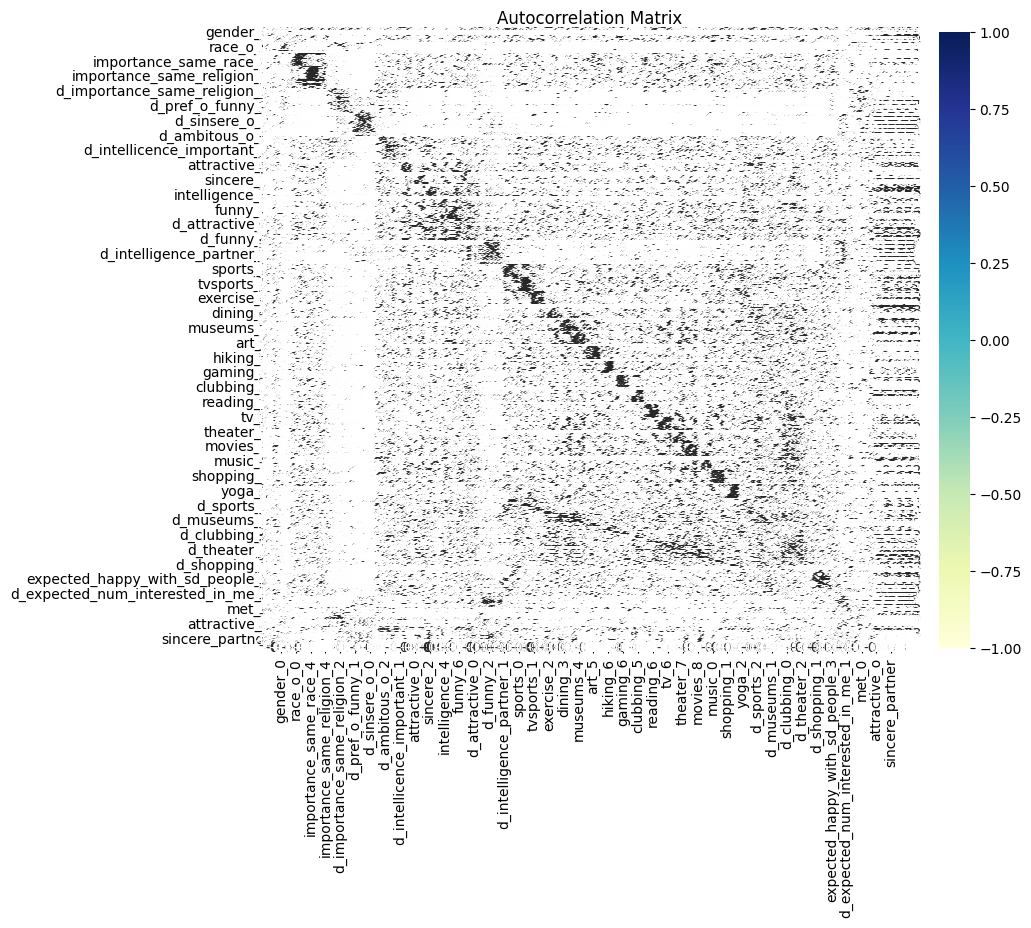

In [ ]:
correlation_matrix = SD_train.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title("Autocorrelation Matrix")
plt.show()

Therefore, as we cannot just choose which variables to remove at random, we want to disregard those that are shown to be truly insignificant.
Therefore, we decided to select the most relevant features that will provide the best prediction based on the Lasso Regression method.

## Lasso Regression

In [ ]:
# Create LASSO model with cross-validation
lasso_model = LassoCV(cv=5) # Removed (, normalize=True) clause

# Create a pipeline to fit the LASSO model
pipeline = Pipeline(steps=[('model', lasso_model)])

# Fit the LASSO model to the data
pipeline.fit(X_train, y_train)

# Get the LASSO coefficients
lasso_coefficients = pipeline.named_steps['model'].coef_

# Get the feature names (including one-hot encoded features)
feature_names = SD_train.columns

# Print the LASSO coefficients along with the feature names
for feature, coef in zip(feature_names, lasso_coefficients):
    print(f"{feature}: {coef}")

# Identify the important features (non-zero coefficients)
important_features = [feature for feature, coef in zip(feature_names, lasso_coefficients) if coef != 0]

# Print the important features
print("\nImportant features:")
print(important_features)

Pipeline(steps=[('model', LassoCV(cv=5))])

gender_0: 0.005053169434317784
gender_1: -1.7069617388813193e-17
d_d_age_0: 0.01837974166204417
d_d_age_1: 0.012371148366610064
d_d_age_2: -0.0021105149917383446
d_d_age_3: -0.006006278545486332
race_0: 0.0
race_1: 0.01069954595760058
race_2: -0.021135593946329533
race_3: -0.0
race_4: -0.0
race_o_0: -0.0
race_o_1: 0.0
race_o_2: -0.01023199399029281
race_o_3: 0.0
race_o_4: -0.0
samerace_0: 0.006077400806652264
samerace_1: -0.0
importance_same_race_0: -0.0
importance_same_race_1: 0.012710397936190387
importance_same_race_2: -0.0
importance_same_race_3: 0.0
importance_same_race_4: -0.002877076059137974
importance_same_race_5: 0.009675191092553602
importance_same_race_6: -0.0
importance_same_race_7: 0.0
importance_same_race_8: -0.0
importance_same_race_9: 0.0023116888723344283
importance_same_race_10: -0.008577111969151324
importance_same_religion_0: -0.0
importance_same_religion_1: -0.014762366491961207
importance_same_religion_2: -0.0
importance_same_religion_3: 0.0
importance_same_relig

In [ ]:
SD_train_lasso = SD_train[important_features]
SD_test_lasso = SD_test[important_features]

In [ ]:
print('from: ', SD_train.shape, ' to: ', SD_train_lasso.shape)

from:  (4372, 458)  to:  (4372, 165)


# Linear Classification II


## Metrics II

In [ ]:
# Create data frame to store metrics obtained with cross validation
metrics_lasso = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [ ]:
X_train_lasso  = SD_train_lasso
X_test_lasso = SD_test_lasso

## LDA II

In [ ]:
lda_model = LinearDiscriminantAnalysis()
lda_model = lda_model.fit(X_train_lasso, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=SD_train_lasso.columns[0:]
means.index = lda_model.classes_
means

Priors: [0.8268527 0.1731473]
Means:



,gender_0,gender_1,d_d_age_0,d_d_age_1,d_d_age_2,d_d_age_3,race_1,race_2,race_o_2,samerace_0,...,met_0,met_1,wave,attractive_o,funny_o,attractive_partner,funny_partner,ambition_partner,like,guess_prob_liked
0.0,0.508160,0.491840,0.263071,0.289627,0.294882,0.152420,0.044260,0.554633,0.550761,0.606086,...,0.964869,0.035131,0.526694,0.596609,0.560317,0.589956,0.615574,0.667524,0.584874,0.499156
1.0,0.509908,0.490092,0.303831,0.335535,0.253633,0.107001,0.068692,0.550859,0.561427,0.602378,...,0.883752,0.116248,0.505416,0.736460,0.687222,0.733355,0.760568,0.735667,0.739498,0.648151


In [ ]:
# Compute cross-validation metrics for LDA
cross_val_results = pd.DataFrame(cross_validate(lda_model , X_train_lasso, y_train, cv = 5, 
                            scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics_lasso.loc['LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.852701,0.69547,0.75015,0.669145


## QDA II

In [ ]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.1).fit(X_train_lasso, y_train)

print('Priors:', qda_model.priors_)
print('Means:\n')
means =pd.DataFrame(qda_model.means_)
means.columns=SD_train_lasso.columns[0:]
means

Priors: [0.8268527 0.1731473]
Means:



,gender_0,gender_1,d_d_age_0,d_d_age_1,d_d_age_2,d_d_age_3,race_1,race_2,race_o_2,samerace_0,...,met_0,met_1,wave,attractive_o,funny_o,attractive_partner,funny_partner,ambition_partner,like,guess_prob_liked
0,0.508160,0.491840,0.263071,0.289627,0.294882,0.152420,0.044260,0.554633,0.550761,0.606086,...,0.964869,0.035131,0.526694,0.596609,0.560317,0.589956,0.615574,0.667524,0.584874,0.499156
1,0.509908,0.490092,0.303831,0.335535,0.253633,0.107001,0.068692,0.550859,0.561427,0.602378,...,0.883752,0.116248,0.505416,0.736460,0.687222,0.733355,0.760568,0.735667,0.739498,0.648151


In [ ]:
cross_val_results = pd.DataFrame(cross_validate(qda_model , X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

metrics_lasso.loc['QDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.852701,0.69547,0.75015,0.669145
QDA,0.767156,0.666635,0.652467,0.712437


## KNN II

In [ ]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
   estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False)
cols = ['param_n_neighbors', 'param_metric',
    'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]
results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

knn_cv.fit(X_train_lasso, y_train)
results_cv = pd.DataFrame(knn_cv.cv_results_)

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
0,1,euclidean,0.790255,0.626311,0.629323,0.624059,0.007914,0.012522,0.012839,0.013193
7,1,minkowski,0.790255,0.626311,0.629323,0.624059,0.007914,0.012522,0.012839,0.013193
14,1,manhattan,0.786367,0.620298,0.622796,0.618568,0.007464,0.013242,0.012712,0.014592
1,3,euclidean,0.812669,0.612357,0.646879,0.598440,0.012003,0.022899,0.030107,0.019238
8,3,minkowski,0.812669,0.612357,0.646879,0.598440,0.012003,0.022899,0.030107,0.019238
15,3,manhattan,0.812212,0.610944,0.645518,0.597133,0.010354,0.018538,0.025435,0.015334
2,5,euclidean,0.824105,0.598226,0.666721,0.583407,0.006847,0.020618,0.025324,0.016291
9,5,minkowski,0.824105,0.598226,0.666721,0.583407,0.006847,0.020618,0.025324,0.016291
16,5,manhattan,0.823190,0.597390,0.663783,0.582854,0.007225,0.021418,0.026614,0.016969
17,7,manhattan,0.822735,0.563130,0.653212,0.557004,0.004756,0.017758,0.025320,0.012541


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 10, 15, 20]},
             refit=False,
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

We will take $k$=1 and distance = 'euclidean' and add $k$-nn to our results table.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train_lasso, y_train)

cross_val_results = pd.DataFrame(cross_validate(knn , X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

metrics_lasso.loc['KNN',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso.sort_values(by='Accuracy', ascending=False)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.852701,0.69547,0.75015,0.669145
QDA,0.767156,0.666635,0.652467,0.712437
KNN,0.785911,0.624472,0.625317,0.625072


## Gaussian Naive Bayes II

In [ ]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_lasso,y_train)

cross_val_results = pd.DataFrame(cross_validate(gaussian_nb , X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics_lasso.loc['Gaussian Naive Bayes',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.852701,0.69547,0.75015,0.669145
Gaussian Naive Bayes,0.772418,0.686878,0.670676,0.752233
QDA,0.767156,0.666635,0.652467,0.712437


## Logistic Regression II

In [ ]:
logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='multinomial')

logreg.fit(X_train_lasso, y_train)

LogisticRegressionCV(Cs=20, cv=10, multi_class='multinomial', random_state=1,
                     scoring='accuracy')

In [ ]:
avg_crossval_scores = logreg.scores_[1].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]
print(best_C)

4.281332398719396


In [ ]:
logreg = LogisticRegression(C=best_C, multi_class='multinomial')
cross_val_results = pd.DataFrame(cross_validate(logreg, X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

metrics_lasso.loc['Logistic Regression',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

metrics_lasso.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.857962,0.716919,0.759236,0.692703
LDA,0.852701,0.69547,0.75015,0.669145
Gaussian Naive Bayes,0.772418,0.686878,0.670676,0.752233
QDA,0.767156,0.666635,0.652467,0.712437


## SVC II

In [ ]:
svc = SVC()
svc = svc.fit(X_train_lasso, y_train)

cross_val_results = pd.DataFrame(cross_validate(svc , X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics_lasso.loc['SVC',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.857962,0.716919,0.759236,0.692703
LDA,0.852701,0.69547,0.75015,0.669145
SVC,0.850867,0.634045,0.783324,0.60744
Gaussian Naive Bayes,0.772418,0.686878,0.670676,0.752233
QDA,0.767156,0.666635,0.652467,0.712437


## Perceptron II

In [ ]:
perceptron = Perceptron()
perceptron = perceptron.fit(X_train_lasso, y_train)

cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics_lasso.loc['Perceptron',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.857962,0.716919,0.759236,0.692703
LDA,0.852701,0.69547,0.75015,0.669145
SVC,0.850867,0.634045,0.783324,0.60744
Perceptron,0.786154,0.680377,0.677017,0.718673
Gaussian Naive Bayes,0.772418,0.686878,0.670676,0.752233
QDA,0.767156,0.666635,0.652467,0.712437


## Gradient Boost II

In [ ]:
gb_classifier = GradientBoostingClassifier()
gb_classifier = gb_classifier.fit(X_train_lasso, y_train)

cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train_lasso, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
metrics_lasso.loc['Gradient Boost',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
metrics_lasso.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Gradient Boost,0.860021,0.700083,0.778402,0.668873
Logistic Regression,0.857962,0.716919,0.759236,0.692703
LDA,0.852701,0.69547,0.75015,0.669145
SVC,0.850867,0.634045,0.783324,0.60744
Perceptron,0.786154,0.680377,0.677017,0.718673
Gaussian Naive Bayes,0.772418,0.686878,0.670676,0.752233
QDA,0.767156,0.666635,0.652467,0.712437


## Generalization Performance II

Using this important feature subset set obtained through Lasso Regression, we have slightly improved our results in terms of model performance. Interestingly, the order in the ranking of models in terms of perfomance metrics is similar. Although still far from the best, Gaussian Naive Bayes has perfomed way better this time, which supports our hypothesis that the previous dataset lead to over fitting.

Once again, Logistic Regression has proved to be the best model, so we shall fit it.

In [ ]:
# Predict using Logistic Regression
y_pred = logreg.fit(X_train_lasso, y_train).predict(X_test_lasso)

# Compute confusion matrix
confusion(y_test, pd.Series(y_pred))

print(classification_report(y_test, y_pred))

predicted,0.0,1.0
target,,
0.0,1652,123
1.0,219,137


              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91      1775
         1.0       0.53      0.38      0.44       356

    accuracy                           0.84      2131
   macro avg       0.70      0.66      0.68      2131
weighted avg       0.82      0.84      0.83      2131



In [ ]:
# Predict using Gradient Boost model
y_pred = gb_classifier.fit(X_train_lasso, y_train).predict(X_test_lasso)

# Compute confusion matrix
confusion(y_test, pd.Series(y_pred))

print(classification_report(y_test, y_pred))

predicted,0.0,1.0
target,,
0.0,1685,90
1.0,236,120


              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1775
         1.0       0.57      0.34      0.42       356

    accuracy                           0.85      2131
   macro avg       0.72      0.64      0.67      2131
weighted avg       0.83      0.85      0.83      2131



Overall, this final result is similar as the one we had obtained prior to performing Lasso Regression, but slightly better. 

# Random Forest and Ensambles

## Resampling

For the train/val/test datasets we will choose **stratified partitions**; what this means is that we will keep the same proportion of yes/no examples in each partition. With imbalanced datasets this is important since a random partition may increase the imbalance if we are unlucky.

In [ ]:
X_train = X1_train
y_train = y1_train

## Metrics

In [ ]:
# Set confusion matrix for displaying results
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [ ]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]
    
    
results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

## Decision Tree

In [ ]:
model_tree = DecisionTreeClassifier().fit(X_train, 
                                          y_train)
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(y_val, y_pred)
print(classification_report(y_val,
                            y_pred,
                            target_names=['no', 'yes'],))
results

predicted,0.0,1.0
target,,
0.0,773,131
1.0,108,81


              precision    recall  f1-score   support

          no       0.88      0.86      0.87       904
         yes       0.38      0.43      0.40       189

    accuracy                           0.78      1093
   macro avg       0.63      0.64      0.64      1093
weighted avg       0.79      0.78      0.79      1093



,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-default,0.781336,0.40399,0.866106,0.635048


We can check if this model is overfitting by computing its train metrics and checking its complexity (is it a huge tree?)

As we can see on our results this model is able to predict the training data perfectly. It is possible that it has adapted to much to it, and because of that, we are obtaining those bad results on our validation partition.

In [ ]:
y_pred_train = model_tree.predict(X_train)

confusion(y_train,y_pred_train)

print(classification_report(y_train,
                            y_pred_train,
                            target_names=['no', 'yes'],))
results

predicted,0.0,1.0
target,,
0.0,2711,0
1.0,0,568


              precision    recall  f1-score   support

          no       1.00      1.00      1.00      2711
         yes       1.00      1.00      1.00       568

    accuracy                           1.00      3279
   macro avg       1.00      1.00      1.00      3279
weighted avg       1.00      1.00      1.00      3279



,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-default,0.781336,0.40399,0.866106,0.635048


In [ ]:
print('Tree depth: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depth: 16
Nodes: 761


We could say that it is a big tree since the number of nodes if¡s considerably big and so is its depth.

In [ ]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:01:52.228227


In [ ]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',
                                                 ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
686,entropy,5,None,3,2,0.664065,0.905689,0.422440,0.838062
689,entropy,5,None,3,5,0.663721,0.905491,0.421952,0.837757
687,entropy,5,None,3,3,0.663721,0.905491,0.421952,0.837757
691,entropy,5,None,4,2,0.663221,0.905294,0.421147,0.837452
679,entropy,5,None,1,5,0.663041,0.905092,0.420991,0.837146


In [ ]:
# These are the best parameters that we have found
best_params = model_5CV.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

We can use our validation metrics to save our best decision tree.

Our metrics show that the performance has improven a bit.

In [ ]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(y_val,y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

predicted,0.0,1.0
target,,
0.0,850,54
1.0,113,76


,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.84721,0.476489,0.910552,0.69352
DT-default,0.781336,0.40399,0.866106,0.635048


Indeed it has improved

## Random Forest

In [ ]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(y_train,pred)

print(classification_report(y_train,
                            pred,
                            target_names=['no', 'yes'],))
print('OOB accuracy=', model_rf1.oob_score_)

predicted,0.0,1.0
target,,
0.0,2711,0
1.0,0,568


              precision    recall  f1-score   support

          no       1.00      1.00      1.00      2711
         yes       1.00      1.00      1.00       568

    accuracy                           1.00      3279
   macro avg       1.00      1.00      1.00      3279
weighted avg       1.00      1.00      1.00      3279

OOB accuracy= 0.8539188777066179


In [ ]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(y_val,y_pred)

Validation Accuracy:0.868252516010979


predicted,0.0,1.0
target,,
0.0,885,19
1.0,125,64


In [ ]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-default,0.868253,0.470588,0.924765,0.697677
DT-best,0.84721,0.476489,0.910552,0.69352
DT-default,0.781336,0.40399,0.866106,0.635048


Let's see if we can improve the random forest by improving the imbalance in our target class.

In [ ]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(y_train, pred)

print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

predicted,0.0,1.0
target,,
0.0,2711,0
1.0,0,568


              precision    recall  f1-score   support

          no       1.00      1.00      1.00      2711
         yes       1.00      1.00      1.00       568

    accuracy                           1.00      3279
   macro avg       1.00      1.00      1.00      3279
weighted avg       1.00      1.00      1.00      3279

OOB accuracy= 0.8496492833180848


In [ ]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(y_val,y_pred)

predicted,0.0,1.0
target,,
0.0,889,15
1.0,140,49


In [ ]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-default,0.868253,0.470588,0.924765,0.697677
DT-best,0.84721,0.476489,0.910552,0.69352
RF-balance,0.858188,0.387352,0.919814,0.653583
DT-default,0.781336,0.40399,0.866106,0.635048


The imbalance was not our problem

In [ ]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:01:42.350288


In [ ]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
34,100,4,6,0.734601,0.911172,0.558030,0.852093
40,None,4,4,0.733387,0.911276,0.555498,0.852094
18,100,4,6,0.731880,0.910265,0.553496,0.850568
46,None,6,6,0.731334,0.899936,0.562731,0.837150
24,None,4,4,0.730576,0.910601,0.550551,0.850873


{'class_weight': 'balanced_subsample',
 'max_depth': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 200}

In [ ]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=100,
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=200)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.852699,0.570667,0.911099,0.740883
RF-default,0.868253,0.470588,0.924765,0.697677
DT-best,0.84721,0.476489,0.910552,0.69352
RF-balance,0.858188,0.387352,0.919814,0.653583
DT-default,0.781336,0.40399,0.866106,0.635048


Feature importance of the variables obtained from decision tree. The first output without the filter of the value 'importance' > 0.005 applied was too big, since there are so many variables. With this it is easier to interpret and value the considerably important features. Now we display the first 41 more important features. 

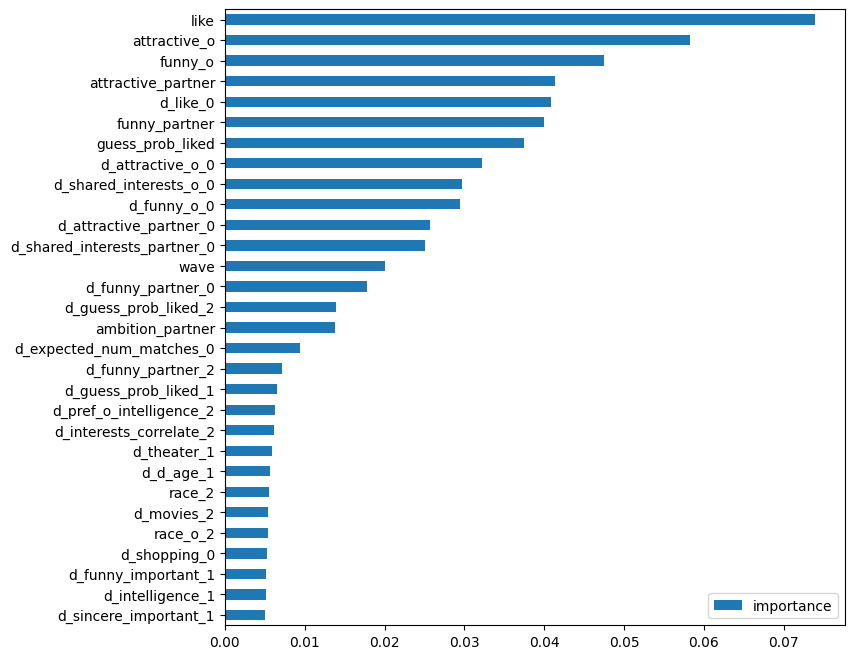

In [ ]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').loc[var_imp['importance'] > 0.005].plot.barh(figsize=(8,8),
                                               legend=True);

## Ensemble

In [ ]:
gauss_nb = GaussianNB()
gauss_nb.fit(X_train,y_train)

y_pred = gauss_nb.predict(X_val)

results.loc['GaussianNB-default',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

GaussianNB()

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.852699,0.570667,0.911099,0.740883
RF-default,0.868253,0.470588,0.924765,0.697677
DT-best,0.84721,0.476489,0.910552,0.69352
GaussianNB-default,0.763038,0.506667,0.84407,0.675368
RF-balance,0.858188,0.387352,0.919814,0.653583
DT-default,0.781336,0.40399,0.866106,0.635048


With a voting classifier we can make the models vote in a "hard" fashion (majority vote) or "soft" fashion (averaging probabilities).

In [ ]:
voting_hard = VotingClassifier([('dt', model_tree), ('rf', model_rf1),
                                ('gnb', gauss_nb)])
voting_hard.fit(X_train, y_train)

y_pred = voting_hard.predict(X_val)

results.loc['voting_hard', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-best','GaussianNB-default','RF-best','voting_hard'],:].sort_values(
    by='F1-score (class 1)',ascending=False)
voting_soft = VotingClassifier([('dt', model_tree), ('rf', model_rf1),
                                ('gnb', gauss_nb)],voting='soft')
voting_soft.fit(X_train, y_train)

y_pred = voting_soft.predict(X_val)

results.loc['voting_soft', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-best','GaussianNB-default','RF-best','voting_hard','voting_soft'],:].sort_values(
    by='F1-score (class 1)',ascending=False)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier(oob_score=True)),
                             ('gnb', GaussianNB())])

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.852699,0.570667,0.911099,0.740883
voting_hard,0.844465,0.519774,0.907205,0.71349
GaussianNB-default,0.763038,0.506667,0.84407,0.675368
DT-best,0.84721,0.476489,0.910552,0.69352


VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier(oob_score=True)),
                             ('gnb', GaussianNB())],
                 voting='soft')

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.852699,0.570667,0.911099,0.740883
voting_soft,0.850869,0.548476,0.910685,0.729581
voting_hard,0.844465,0.519774,0.907205,0.71349
GaussianNB-default,0.763038,0.506667,0.84407,0.675368
DT-best,0.84721,0.476489,0.910552,0.69352


Now we can make a voting classifier with our best models.

In [ ]:
voting_best = VotingClassifier([('dt', model_tree),
                                 ('rf', model_rf1)],voting='soft')
voting_best.fit(X_train, y_train)

y_pred = voting_best.predict(X_val)

results.loc['voting_best', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-best','RF-best','voting_best'],:].sort_values(by='F1-score (class 1)',ascending=False)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier(oob_score=True))],
                 voting='soft')

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-best,0.852699,0.570667,0.911099,0.740883
DT-best,0.84721,0.476489,0.910552,0.69352
voting_best,0.78591,0.415,0.868981,0.64199


In [ ]:
#y_pred = rf_model_tuned.predict(X_test)

#print(classification_report(y_test,y_pred))
#confusion(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1775
         1.0       0.48      0.48      0.48       356

    accuracy                           0.82      2131
   macro avg       0.69      0.69      0.69      2131
weighted avg       0.83      0.82      0.83      2131



predicted,0.0,1.0
target,,
0.0,1586,189
1.0,184,172
